In [375]:
# Cargar librerías
import pandas as pd  # Manejo de dataframes
import numpy as np  # Manejo de arrays

In [376]:
# Cargar datos
df = pd.read_csv("data/df.csv", index_col=0)
df.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,...,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,target,retirementDate,retirementType,resignationReason
EmployeeID,,,,,,,,,,,,,,,,,,,,,
1,51,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,...,0,3.0,4.0,2.0,3,3,0,NaN,No,No
2,31,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,...,4,3.0,2.0,4.0,2,4,1,2016-10-15,Resignation,Others
3,32,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,...,3,2.0,2.0,1.0,3,3,0,NaN,No,No
4,38,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,...,5,4.0,4.0,3.0,2,3,0,NaN,No,No
5,32,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,...,4,4.0,1.0,3.0,3,3,0,NaN,No,No


In [377]:
# Quitar retirementDate, retirementType y retirementReason porque puede generar un sesgo en el modelo
df.drop(["retirementDate", "retirementType", "resignationReason"], axis=1, inplace=True)


# Reemplazar los valores nan de EnvironmentSatisfaction, JobSatisfaction y WorkLifeBalance por la moda de ese empleado en su departamento
df["EnvironmentSatisfaction"] = df.groupby("Department")[
    "EnvironmentSatisfaction"
].transform(lambda x: x.fillna(x.mode()[0]))

df["JobSatisfaction"] = df.groupby("Department")["JobSatisfaction"].transform(
    lambda x: x.fillna(x.mode()[0])
)
df["WorkLifeBalance"] = df.groupby("Department")["WorkLifeBalance"].transform(
    lambda x: x.fillna(x.mode()[0])
)


# Se categorizaron las variables numéricas que en realidad son categóricas
convert_dict = {
    "Education": str,
    "JobLevel": str,
    "StockOptionLevel": str,
    "EnvironmentSatisfaction": str,
    "JobSatisfaction": str,
    "WorkLifeBalance": str,
    "JobInvolvement": str,
    "PerformanceRating": str,
}
# Con el diccionario convertimos las variables a string
df = df.astype(convert_dict)

In [378]:
from sklearn.model_selection import train_test_split

# Separación de caracteristicas y target (X , y)
y = df.target
X = df.drop(["target"], axis=1)

# Separación en conjuntos de entrenamiento y validación con 90% de muestras para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_test.shape)

# Seleccionar variables numéricas int64 y float64
numeric_columns = list(X.select_dtypes(include=["int64", "float64"]).columns)
categorical_columns = list(X.select_dtypes("object").columns)

Tamaño del conjunto de entrenamiento: (3943, 24)
Tamaño del conjunto de validación: (439, 24)


In [379]:
# Estandarizar las variables numéricas
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Convertir a dummy las variables categóricas
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [380]:
# Lista de modelos que tienen más interpretabilidad para clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  # Ensamble con bagging
from sklearn.ensemble import GradientBoostingClassifier  # Ensamble con boosting

models = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
}

# Entrenar los modelos
for model in models:
    models[model].fit(X_train, y_train)

# Evaluar los modelos con el conjunto de validación con métrica para clasificación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for model in models:
    y_pred = models[model].predict(X_test)
    print(model)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("")

# Tabla de las 15 características más importantes para DecisionTreeClassifier y RandomForestClassifier
importances = pd.DataFrame(
    {
        "DecisionTreeClassifier": models["DecisionTreeClassifier"].feature_importances_,
        "RandomForestClassifier": models["RandomForestClassifier"].feature_importances_,
    },
    index=X_train.columns,
)
importances["mean"] = importances.mean(axis=1)
importances.sort_values(by="mean", ascending=False).head(15)

LogisticRegression
Accuracy: 0.8815489749430524
Precision: 0.6111111111111112
Recall: 0.19642857142857142
F1: 0.2972972972972973

DecisionTreeClassifier
Accuracy: 0.9931662870159453
Precision: 0.9491525423728814
Recall: 1.0
F1: 0.9739130434782608

RandomForestClassifier
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0

GradientBoostingClassifier
Accuracy: 0.9111617312072893
Precision: 0.9473684210526315
Recall: 0.32142857142857145
F1: 0.48



,DecisionTreeClassifier,RandomForestClassifier,mean
MonthlyIncome,0.144340,0.063769,0.104054
TotalWorkingYears,0.121717,0.067688,0.094703
Age,0.075261,0.075235,0.075248
PercentSalaryHike,0.046870,0.044057,0.045464
NumCompaniesWorked,0.050188,0.037961,0.044074
DistanceFromHome,0.037954,0.048770,0.043362
YearsWithCurrManager,0.035238,0.042010,0.038624
YearsAtCompany,0.009245,0.056022,0.032633
YearsSinceLastPromotion,0.024535,0.031090,0.027812
MaritalStatus_Single,0.028353,0.022505,0.025429


# LogisticRegression

F1 score: 0.2972972972972973


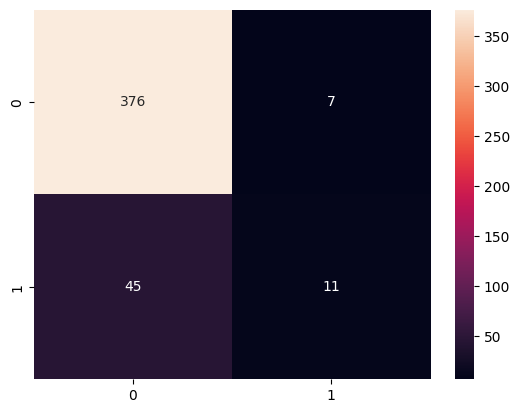

,feature,importance
11,BusinessTravel_Travel_Frequently,0.763819
58,WorkLifeBalance_1.0,0.737054
45,MaritalStatus_Single,0.701338
50,EnvironmentSatisfaction_1.0,0.670905
21,EducationField_Human Resources,0.587871
54,JobSatisfaction_1.0,0.565720
8,YearsSinceLastPromotion,0.529885
39,JobRole_Research Director,0.450934
13,Department_Human Resources,0.407815
3,NumCompaniesWorked,0.323916


In [335]:
# Modelo de regresión logística con F1 como métrica de evaluación
# Por su facilidad de interpretación ya que en este caso requerimos ver las variables más importantes


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Entrenamiento del modelo
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predicción del modelo
y_pred = lr.predict(X_test)

# Evaluación del modelo
print("F1 score:", f1_score(y_test, y_pred))

# Matriz de confusión gráfica
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d")
plt.show()

# Importancia de las variables
importancia = pd.DataFrame(
    {"feature": X_train.columns, "importance": lr.coef_[0]}
).sort_values("importance", ascending=False)
importancia.head(15)

# DecisionTreeClassifier

F1 score: 0.9739130434782608


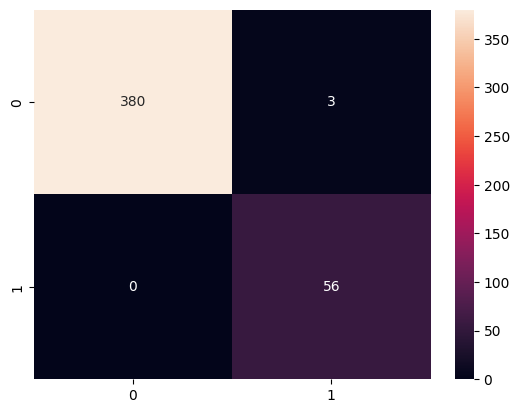

,feature,importance
2,MonthlyIncome,0.125029
5,TotalWorkingYears,0.108717
0,Age,0.058294
4,PercentSalaryHike,0.056922
3,NumCompaniesWorked,0.049415
1,DistanceFromHome,0.039092
7,YearsAtCompany,0.038901
9,YearsWithCurrManager,0.030590
6,TrainingTimesLastYear,0.030115
50,EnvironmentSatisfaction_1.0,0.028743


In [334]:
# Modelo de árbol de decisión con F1 como métrica de evaluación
from sklearn.tree import DecisionTreeClassifier

# Entrenamiento del modelo
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Predicción del modelo
y_pred = dt.predict(X_test)

# Evaluación del modelo
print("F1 score:", f1_score(y_test, y_pred))

# Matriz de confusión gráfica
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d")
plt.show()

# 15 variables más importantes
importancia = pd.DataFrame(
    {"feature": X_train.columns, "importance": dt.feature_importances_}
).sort_values("importance", ascending=False)
importancia.head(15)